In [1]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=5000)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('NFLX',
                      start=start_date,
                      end=end_date,
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

           Date        Open        High         Low       Close   Adj Close  \
3439 2024-06-10  641.010010  644.789978  635.590027  644.500000  644.500000   
3440 2024-06-11  640.719971  650.190002  640.520020  648.549988  648.549988   
3441 2024-06-12  652.210022  655.780029  643.109985  650.059998  650.059998   
3442 2024-06-13  644.000000  655.250000  642.349976  653.260010  653.260010   
3443 2024-06-14  655.049988  675.580017  652.640015  669.380005  669.380005   

       Volume  
3439  2066800  
3440  2167400  
3441  2094400  
3442  1863600  
3443  4403600  


In [2]:

data.to_csv('data.csv')


In [3]:

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/data.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2010, 10, 8, 0, 0),
  datetime.datetime(2010, 10, 11, 0, 0),
  datetime.datetime(2010, 10, 12, 0, 0),
  datetime.datetime(2010, 10, 13, 0, 0),
  datetime.datetime(2010, 10, 14, 0, 0),
  datetime.datetime(2010, 10, 15, 0, 0),
  datetime.datetime(2010, 10, 18, 0, 0),
  datetime.datetime(2010, 10, 19, 0, 0),
  datetime.datetime(2010, 10, 20, 0, 0),
  datetime.datetime(2010, 10, 21, 0, 0)],
 [21.719999313354492,
  21.534286499023438,
  21.959999084472656,
  22.58571434020996,
  21.98714256286621,
  21.932857513427734,
  22.34428596496582,
  21.472856521606445,
  21.428571701049805,
  24.219999313354492])

In [4]:
df = data[['Date', 'Close']]

df

,Date,Close
0,2010-10-08,21.377144
1,2010-10-11,21.955713
2,2010-10-12,22.198570
3,2010-10-13,22.087143
4,2010-10-14,21.825714
...,...,...
3439,2024-06-10,644.500000
3440,2024-06-11,648.549988
3441,2024-06-12,650.059998
3442,2024-06-13,653.260010


In [5]:
df.index = df.pop('Date')
df

,Close
Date,
2010-10-08,21.377144
2010-10-11,21.955713
2010-10-12,22.198570
2010-10-13,22.087143
2010-10-14,21.825714
...,...
2024-06-10,644.500000
2024-06-11,648.549988
2024-06-12,650.059998


In [6]:

timesteps = df.index.to_numpy()
prices = df["Close"].to_numpy()

timesteps[:10], prices[:10]

(array(['2010-10-08T00:00:00.000000000', '2010-10-11T00:00:00.000000000',
        '2010-10-12T00:00:00.000000000', '2010-10-13T00:00:00.000000000',
        '2010-10-14T00:00:00.000000000', '2010-10-15T00:00:00.000000000',
        '2010-10-18T00:00:00.000000000', '2010-10-19T00:00:00.000000000',
        '2010-10-20T00:00:00.000000000', '2010-10-21T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([21.37714386, 21.95571327, 22.19857025, 22.08714294, 21.82571411,
        22.24571419, 21.8571434 , 21.33285713, 21.87857056, 24.67000008]))

In [7]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2755, 689, 2755, 689)

In [8]:
# Pencere ve ufuk boyutu için global değişkenler ayarlayalım
HORIZON = 1 # gelecek 1 günü tahmin et
WINDOW_SIZE = 7 # tahminde bulunmak için geçen haftanın  verilerini kullanın

In [9]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
df.head()

,Close
Date,
2010-10-08,21.377144
2010-10-11,21.955713
2010-10-12,22.198570
2010-10-13,22.087143
2010-10-14,21.825714


In [10]:
import numpy as np


In [11]:
# Add windowed columns
df_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  df_nbeats[f"Close+{i+1}"] = df_nbeats["Close"].shift(periods=i+1)
df_nbeats.head()

,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,
2010-10-08,21.377144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-11,21.955713,21.377144,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-12,22.198570,21.955713,21.377144,NaN,NaN,NaN,NaN,NaN
2010-10-13,22.087143,22.198570,21.955713,21.377144,NaN,NaN,NaN,NaN
2010-10-14,21.825714,22.087143,22.198570,21.955713,21.377144,NaN,NaN,NaN


In [12]:
# Create X (windows) and y (horizons) features
X = df_nbeats.dropna().drop("Close", axis=1).astype(np.float32)
y = df_nbeats.dropna()["Close"].astype(np.float32)
X.head()

,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,
2010-10-19,21.857143,22.245714,21.825714,22.087143,22.198570,21.955713,21.377144
2010-10-20,21.332857,21.857143,22.245714,21.825714,22.087143,22.198570,21.955713
2010-10-21,21.878571,21.332857,21.857143,22.245714,21.825714,22.087143,22.198570
2010-10-22,24.670000,21.878571,21.332857,21.857143,22.245714,21.825714,22.087143
2010-10-25,24.014286,24.670000,21.878571,21.332857,21.857143,22.245714,21.825714


In [13]:
# Make features and labels
y = df_nbeats.dropna()["Close"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2749, 2749, 688, 688)

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [15]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

## N-BEATS algoritması için hiperparametrelerin ayarlanması

In [16]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size: int,     # Giriş boyutu
                 theta_size: int,     # Theta boyutu
                 horizon: int,        # Uzun dönem tahmin aralığı
                 n_neurons: int,      # Sinir ağı katmanındaki nöron sayısı
                 n_layers: int,       # Sinir ağı katmanındaki katman sayısı
                 **kwargs):           # Diğer argümanlar için **kwargs kullanılır
        super().__init__(**kwargs)  # Üst sınıfın (Layer) yapıcı metodunu çağırarak başlatma
        self.input_size = input_size  # Giriş boyutunu sınıf özelliklerine atama
        self.theta_size = theta_size  # Theta boyutunu sınıf özelliklerine atama
        self.horizon = horizon        # Uzun dönem tahmin aralığını sınıf özelliklerine atama
        self.n_neurons = n_neurons    # Sinir ağı katmanındaki nöron sayısını sınıf özelliklerine atama
        self.n_layers = n_layers      # Sinir ağı katmanındaki katman sayısını sınıf özelliklerine atama

        # N-BEATS bloğu, 4 tam bağlantılı (fully connected) katman içerir, her biri ReLU aktivasyonuyla
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        # Bloğun çıktısı, lineer aktivasyona sahip bir theta katmanıdır
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs):
        x = inputs  # Giriş verisini x değişkenine atama
        # Giriş verisini N-BEATS bloğundaki her bir gizli katmandan geçirme
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)  # Theta katmanından theta çıktısını elde etme
        # theta'dan geriye doğru tahmin (backcast) ve ileriye doğru tahmin (forecast) elde etme
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast


In [17]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
# Dummy NBeatsBlock katmanını oluşturma, girişleri ve çıktıları temsil etmek için
tf.random.set_seed(42)  # Rastgele sayı üretimi için TensorFlow'un rastgele tohumunu ayarlama
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)


In [18]:
# Create dummy inputs (have to be same size as input_size)
# Dummy girişleri oluşturma (input_size ile aynı boyutta olmalıdır)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs


<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [19]:
# Pass dummy inputs to dummy NBeatsBlock layer
# Sahte girişleri sahte NBeatsBlock katmanına geçirme
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
# Bunlar, theta katmanının aktivasyon çıktılarıdır (modelin eğitilmemiş olması nedeniyle rastgele olacaklardır)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")


Backcast: [ 0.15696631  0.38943383  0.48024312  0.63460374 -0.05043162 -0.1785816
  0.6011864 ]
Forecast: -0.18165726959705353


In [20]:
HORIZON = 1
WINDOW_SIZE = 7

In [21]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
df.head()

,Close
Date,
2010-10-08,21.377144
2010-10-11,21.955713
2010-10-12,22.198570
2010-10-13,22.087143
2010-10-14,21.825714


In [22]:
# Add windowed columns
df_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  df_nbeats[f"Close+{i+1}"] = df_nbeats["Close"].shift(periods=i+1)
df_nbeats.head()

,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,
2010-10-08,21.377144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-11,21.955713,21.377144,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-12,22.198570,21.955713,21.377144,NaN,NaN,NaN,NaN,NaN
2010-10-13,22.087143,22.198570,21.955713,21.377144,NaN,NaN,NaN,NaN
2010-10-14,21.825714,22.087143,22.198570,21.955713,21.377144,NaN,NaN,NaN


In [23]:
# Make features and labels
X = df_nbeats.dropna().drop("Close", axis=1)
y = df_nbeats.dropna()["Close"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2749, 2749, 688, 688)

In [24]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [25]:
# Values from N-BEATS paper
N_EPOCHS = 500
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [26]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [27]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_1 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_1_NBEATS")

# 8. Compile model with MAE loss
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_1.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])

CPU times: user 2min 41s, sys: 5.02 s, total: 2min 46s
Wall time: 3min 7s


In [28]:
# Evaluate N-BEats model on the test dataset
model_1.evaluate(test_dataset)

1/1 [==============================] - 0s 27ms/step - loss: 10.5480


10.548025131225586

In [29]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [30]:
# Make predictions with N-BEATS model
model_1_preds = make_preds(model_1, test_dataset)
model_1_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([574.72833, 570.0471 , 576.1887 , 580.879  , 583.0431 , 585.30975,
       580.82623, 585.1521 , 594.47296, 599.906  ], dtype=float32)>

In [31]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [32]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [33]:
# Evaluate N-BEATS model preds
model_1_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_1_preds)
model_1_results

{'mae': 10.548025,
 'mse': 226.96964,
 'rmse': 15.065512,
 'mape': 2.799318,
 'mase': 1.3861775}

Bu, daha küçük ağların gücünün yanı sıra tüm büyük modellerin belirli bir veri türü için daha uygun olmadığı gerçeğini de göstermektedir.

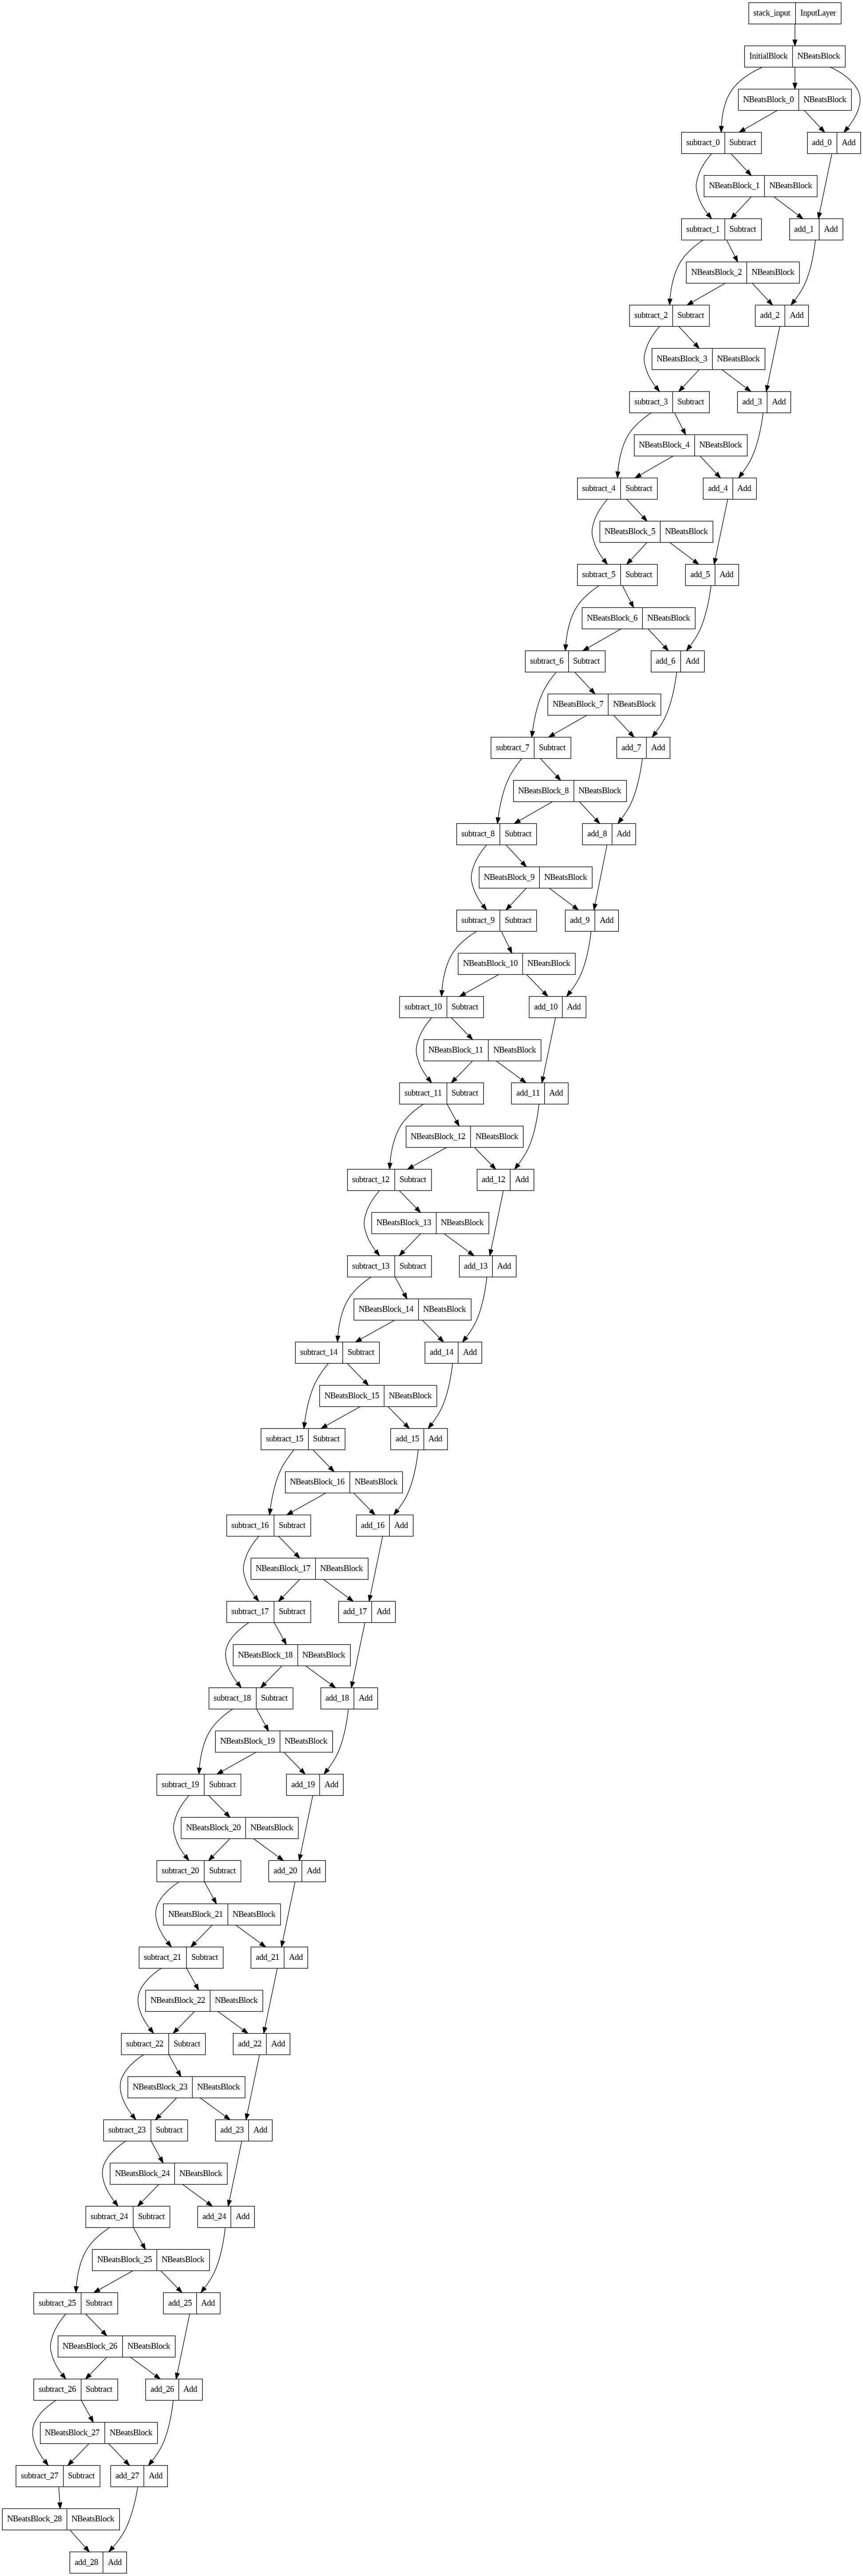

In [34]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_1)